# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5


---
__Name:__  Victoria Baker  
__Class:__ MIDS w261 (Section 2)     
__Email:__  victoria.baker@iSchool.Berkeley.edu     
__Week:__   5

__Due Time:__ 2 Phases. 

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as AltaScale's PaaS or on AWS) and is due Tuesday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the AltaScale cluster and will be due Tuesday, Week 7 by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. This will be a group exercise 


# Table of Contents <a name="TOC"></a> 

1.  [HW Instructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
       
    5.4.  [HW5.4](#5.4)    
    5.5.  [HW5.5](#5.5)    
    5.6.  [HW5.6](#5.6)    
    5.7.  [HW5.7](#5.7)    
    5.8.  [HW5.8](#5.8)    
    5.9.  [HW5.9](#5.9)    
   

<a name="1"></a>
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale   
DATSCIW261 ASSIGNMENT #5

Version 2017-9-2 


### IMPORTANT

This homework must be completed in the cloud 

### === INSTRUCTIONS for SUBMISSIONS ===   
Follow the instructions for submissions carefully.

Each student has a `HW-<user>` repository for all assignments.   

Click this link to enable you to create a github repo within the MIDS261 Classroom:   
https://classroom.github.com/assignment-invitations/3b1d6c8e58351209f9dd865537111ff8   
and follow the instructions to create a HW repo.

Push the following to your HW github repo into the master branch:
* Your local HW5 directory. Your repo file structure should look like this:

```
HW-<user>
    --HW3
       |__MIDS-W261-HW-03-<Student_id>.ipynb
       |__MIDS-W261-HW-03-<Student_id>.pdf
       |__some other hw3 file
    --HW4
       |__MIDS-W261-HW-04-<Student_id>.ipynb
       |__MIDS-W261-HW-04-<Student_id>.pdf
       |__some other hw4 file
    etc..
```    

<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* See async and live lectures for this week

<a name="3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="5.4"></a> 
# PHASE 2
----------

# HW 5.4   
## Full-scale experiment on Google N-gram data on the CLOUD
__ Once you are happy with your test results __ proceed to generating  your results on the Google n-grams dataset. 

## 3.  HW5.4.0  <a name="5.4.0"></a> Run systems tests on the CLOUD  (PHASE 2)
[Back to Table of Contents](#TOC)

Repeat HW5.3.0 (using the same small data sources that were used in HW5.3.0) on ** the cloud** (e.g., AltaScale / AWS/ SoftLayer/ Azure). Make sure all tests give correct results! Good luck out there!

In [1]:
import os
USER = !whoami
USER = USER[0]
OUTPUT_PATH_BASE = '/user/{USER}'.format(USER=USER)

In [36]:
#if they're not installed, install mathplotlib and numpy
!pip install matplotlib
!pip install numpy

In [192]:
%%writefile buildStripes.py
#!~/anaconda2/bin/python

from __future__ import division
import re
import mrjob
import json
import numpy as np
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import combinations

class MRbuildStripes(MRJob):
#START SUDENT CODE531_STRIPES

    def mapper(self, _, line):
        #Emit co-occurrence combos for each pair of words stored as stripes
        line = line.strip().split('\t')
        
        #The full text of the ngram
        ngram = line[0].lower()
        count = int(line[1])
        
        #words in ngram
        words = ngram.split(" ")
        output = {}
        
        #add each combination of co-occurring words to stripe
        for w1, w2 in combinations(words, 2):
            
            if w1 in output.keys():
                output[w1][w2] = output[w1].get(w2,0) + count
            else:
                output[w1] = {w2:count}
            
            #mirroring word order so both a,b and b,a get added
            if w2 in output.keys():      
                output[w2][w1] = output[w2].get(w1,0) + count
            else:
                output[w2] = {w1:count}

        for word, groups in output.iteritems():
            yield word, groups

    def reducer(self, word, groups):
        #combine stripe totals
        output_dict = {}
        for co in groups:
            for coWord, count in co.iteritems():
                output_dict[coWord] = output_dict.get(coWord,0) + count
        yield word, output_dict     
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.reducer,
                reducer = self.reducer
                  )        
        ] 
#END SUDENT CODE531_STRIPES
  
if __name__ == '__main__':
      MRbuildStripes.run()

Writing buildStripes.py


In [238]:
%%writefile invertedIndex.py
#!~/anaconda2/bin/python

from __future__ import division
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from ast import literal_eval
from math import sqrt

class MRinvertedIndex(MRJob):
    
#START SUDENT CODE531_INV_INDEX
    def mapper(self, _, line):
        line = line.strip().split('\t')
        word = literal_eval(line[0])
        groups = literal_eval(line[1]) #stripes    
        
        stripe_length = len(groups) #co-occurrences
        for word2, count in groups.iteritems():
            yield word2, (word, stripe_length)

    def combiner(self, word2, word_1_counts):
        yield word2, dict(word_1_counts)
        
    def reducer(self, word, groups):
        output_dict = {}
        for g in groups:
            for second_word, count in g.iteritems():
                output_dict[second_word] = output_dict.get(second_word, 0) + count
        yield word, output_dict
    
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer,
                jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
                  )
        ]

#END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Overwriting invertedIndex.py


#### Note:
I couldn't get my similarity class right in the phase 1 homework when I turned it in on time, but I was able to figure out my issues with it and got it working for phase 2. The "new and improved" file is below.

In [128]:
%%writefile similarity.py
#!~/anaconda2/bin/python

from __future__ import division
import collections
import re
import csv
import json
import numpy as np
from math import sqrt
from itertools import combinations
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
    
    #turn sorting on
    SORT_VALUES = True
    
    def mapper(self, _, line):
        word, stripe = line.split('\t')
        stripe = json.loads(stripe)
        docs = stripe.keys()
        for words in combinations(docs, 2):
            pair = sorted(list(words))
            w1 = pair[0]
            w2 = pair[1]
            yield (w1,w2), [1, stripe[w1], stripe[w2]]
                                        
    def reducer(self, pair, stripes):
        a_b = 0
        
        for stripe in stripes:
            pairCount, a, b = stripe[:3]
            a_b += pairCount
            
        jaccard = a_b / float(a + b - a_b)
        cosine = a_b * (1 / sqrt(a) * 1 / sqrt(b))
        overlap = a_b / min(a, b)
        dice = (2 * a_b) / (a + b)
        avg = (jaccard + cosine + overlap + dice ) / float(4)
        
        yield avg, [pair, cosine, jaccard, overlap, dice]
    
    def reducer2(self, word, values):
        for value in values:
            yield word, value

    def steps(self):
        return [MRStep(
            mapper = self.mapper,
            reducer = self.reducer,
        ),
            MRStep(
            reducer = self.reducer2,
            jobconf = {
                'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                       'mapred.text.key.comparator.options':'-k1,1rn',
                       'mapred.reduce.tasks' : 1}   
        )
               ]
    
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting similarity.py


In [6]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


In [7]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [8]:
!hdfs dfs -rm --recursive systems_test_stripes_1
!python buildStripes.py -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt > systems_test_stripes_1

-rm: Illegal option --recursive
Usage: hadoop fs [generic options] -rm [-f] [-r|-R] [-skipTrash] <src> ...
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.victoriabaker.20171010.230901.492423
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.victoriabaker.20171010.230901.492423/output...
Removing temp directory /tmp/buildStripes.victoriabaker.20171010.230901.492423...


In [9]:
!cat systems_test_stripes_1

"a"	{"limited":55,"sea":62,"general":92,"female":447,"in":1201,"religious":59,"george":92,"biography":92,"city":62,"for":59,"tales":123,"child's":1099,"forms":116,"wales":1099,"christmas":1099,"government":102,"collection":239,"by":62,"case":604,"circumstantial":62,"fairy":123,"of":1011,"study":604,"bill":59,"establishing":59,"narrative":62,"the":124}
"bill"	{"a":59,"religious":59,"for":59,"establishing":59}
"biography"	{"a":92,"of":92,"george":92,"general":92}
"by"	{"a":62,"city":62,"the":62,"sea":62}
"case"	{"a":604,"limited":55,"government":102,"of":502,"study":604,"female":447,"in":102}
"child's"	{"a":1099,"wales":1099,"christmas":1099,"in":1099}
"christmas"	{"a":1099,"wales":1099,"in":1099,"child's":1099}
"circumstantial"	{"a":62,"of":62,"the":62,"narrative":62}
"city"	{"a":62,"the":62,"by":62,"sea":62}
"collection"	{"a":239,"of":355,"fairy":123,"tales":123,"forms":116}
"establishing"	{"a":59,"bill":59,"religious":59,"for":59}
"fairy"	{"a":123,"of":123,"tales":123,"collection":123

In [10]:
!hdfs dfs -rm --recursive systems_test_stripes_2
!python buildStripes.py -r local atlas-boon-systems-test.txt > systems_test_stripes_2

-rm: Illegal option --recursive
Usage: hadoop fs [generic options] -rm [-f] [-r|-R] [-skipTrash] <src> ...
No configs found; falling back on auto-configuration
Creating temp directory /tmp/buildStripes.victoriabaker.20171010.230907.943370
Running step 1 of 1...
Streaming final output from /tmp/buildStripes.victoriabaker.20171010.230907.943370/output...
Removing temp directory /tmp/buildStripes.victoriabaker.20171010.230907.943370...


In [11]:
!cat systems_test_stripes_2

"atlas"	{"dipped":15,"boon":50}
"boon"	{"atlas":50,"dipped":10,"cava":10}
"cava"	{"dipped":10,"boon":10}
"dipped"	{"atlas":15,"boon":10,"cava":10}


In [12]:
with open("systems_test_stripes_3", "w") as f:
    f.writelines([
        '"DocA"\t{"X":20, "Y":30, "Z":5}\n',
        '"DocB"\t{"X":100, "Y":20}\n',  
        '"DocC"\t{"M":5, "N":20, "Z":5, "Y":1}\n'
    ])
!cat systems_test_stripes_3 

"DocA"	{"X":20, "Y":30, "Z":5}
"DocB"	{"X":100, "Y":20}
"DocC"	{"M":5, "N":20, "Z":5, "Y":1}


In [13]:
!python invertedIndex.py -r local systems_test_stripes_1 > systems_test_index_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.victoriabaker.20171010.230919.709700
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.victoriabaker.20171010.230919.709700/output...
Removing temp directory /tmp/invertedIndex.victoriabaker.20171010.230919.709700...


In [14]:
!python invertedIndex.py -r local systems_test_stripes_2 > systems_test_index_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.victoriabaker.20171010.230926.960786
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.victoriabaker.20171010.230926.960786/output...
Removing temp directory /tmp/invertedIndex.victoriabaker.20171010.230926.960786...


In [15]:
!cat systems_test_index_2

"atlas"	{"dipped":3,"boon":3}
"boon"	{"atlas":2,"dipped":3,"cava":2}
"cava"	{"dipped":3,"boon":3}
"dipped"	{"atlas":2,"boon":3,"cava":2}


In [16]:
!python invertedIndex.py -r local systems_test_stripes_3 > systems_test_index_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.victoriabaker.20171010.230932.978010
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.victoriabaker.20171010.230932.978010/output...
Removing temp directory /tmp/invertedIndex.victoriabaker.20171010.230932.978010...


In [17]:
!cat systems_test_index_3

"M"	{"DocC":4}
"N"	{"DocC":4}
"X"	{"DocB":2,"DocA":3}
"Y"	{"DocB":2,"DocC":4,"DocA":3}
"Z"	{"DocC":4,"DocA":3}


In [18]:
import json

for i in range(1,4):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("systems_test_index_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            word,stripe = line.split("\t")
            stripe = json.loads(stripe)
            stripe = stripe.items()
            stripe = sorted(stripe, key=lambda tup: tup[0])
            #print stripe
            #print type(stripe.items())
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format(
                  (word), stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))


————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
             "a" |          bill 4 |     biography 4 |            by 4
          "bill" |            a 27 |  establishing 4 |           for 4
     "biography" |            a 27 |       general 4 |        george 4
            "by" |            a 27 |          city 4 |           sea 4
          "case" |            a 27 |        female 4 |    government 4
       "child's" |            a 27 |     christmas 4 |            in 7
     "christmas" |            a 27 |       child's 4 |            in 7
"circumstantial" |            a 27 |     narrative 4 |           of 16
          "city" |            a 27 |            by 4 |           sea 4
    "collection" |            a 27 |         fairy 4 |         forms 3
  "establishing" |            a 27 |          bill 4 |

In [129]:
!python similarity.py systems_test_index_1

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.victoriabaker.20171011.040620.326823
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/similarity.victoriabaker.20171011.040620.326823/output...
0.1263736264	[["in","the"],0.1428571429,0.0769230769,0.1428571429,0.1428571429]
0.1319078947	[["bill","of"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["child's","of"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["christmas","of"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["establishing","of"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["for","of"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["of","religious"],0.125,0.0526315789,0.25,0.1]
0.1319078947	[["of","wales"],0.125,0.0526315789,0.25,0.1]
0.1566516521	[["collection","in"],0.1690308509,0.0909090909,0.2,0.1666666667]
0.1802001046	[["bill","case"],0.1889822365,0.1,0.25,0.1818181818]
0.1802001046	[["bill","in"],0.1889822365,0.1,0.25,0.1818181818]
0.1802001046	[["bill","st

In [132]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py \
        -r hadoop systems_test_index_1 \
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/11 04:08:19 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.victoriabaker.20171011.040820.655065
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/similarity.victoriabaker.20171011.040820.655065/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7598370431922033683.jar tmpDir=null
  Timeline service address: http:/

In [134]:
!hadoop fs -cat {OUTPUT_PATH}/* > systems_test_similarities_1

In [136]:
!python similarity.py systems_test_index_2

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.victoriabaker.20171011.044203.820177
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/similarity.victoriabaker.20171011.044203.820177/output...
0.3895620726	[["atlas","boon"],0.4082482905,0.25,0.5,0.4]
0.3895620726	[["atlas","dipped"],0.4082482905,0.25,0.5,0.4]
0.3895620726	[["boon","cava"],0.4082482905,0.25,0.5,0.4]
0.3895620726	[["cava","dipped"],0.4082482905,0.25,0.5,0.4]
0.625	[["boon","dipped"],0.6666666667,0.5,0.6666666667,0.6666666667]
1.0	[["atlas","cava"],1.0,1.0,1.0,1.0]
Removing temp directory /tmp/similarity.victoriabaker.20171011.044203.820177...


In [137]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py \
        -r hadoop systems_test_index_2 \
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/11 04:42:19 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.victoriabaker.20171011.044220.821694
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/similarity.victoriabaker.20171011.044220.821694/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3279028328430229304.jar tmpDir=null
  Timeline service address: http:/

In [139]:
!hadoop fs -cat {OUTPUT_PATH}/* > systems_test_similarities_2

In [141]:
!python similarity.py systems_test_index_3

No configs found; falling back on auto-configuration
Creating temp directory /tmp/similarity.victoriabaker.20171011.044423.115105
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/similarity.victoriabaker.20171011.044423.115105/output...
0.346721681	[["DocB","DocC"],0.3535533906,0.2,0.5,0.3333333333]
0.5538613768	[["DocA","DocC"],0.5773502692,0.4,0.6666666667,0.5714285714]
0.8207908119	[["DocA","DocB"],0.8164965809,0.6666666667,1.0,0.8]
Removing temp directory /tmp/similarity.victoriabaker.20171011.044423.115105...


In [142]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}
!python similarity.py \
        -r hadoop systems_test_index_3 \
        --output-dir={OUTPUT_PATH} \
        --no-output

17/10/11 04:44:31 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/.Trash/Current
No configs found; falling back on auto-configuration
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity.victoriabaker.20171011.044432.581541
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/similarity.victoriabaker.20171011.044432.581541/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8030930296010591253.jar tmpDir=null
  Timeline service address: http:/

In [143]:
!hadoop fs -cat {OUTPUT_PATH}/* > systems_test_similarities_3

In [147]:
import json
for i in range(1,4):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>15} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
          "average", "pair", "cosine", "jaccard", "overlap", "dice")
    print '-'*110

    with open("systems_test_similarities_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg, stripe = line.split("\t")
            stripe = json.loads(stripe)
            pair = stripe[0]
            print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
              float(avg), pair, float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))
                #float(0), pair, float(cosine), float(0), float(0), float(0))
 

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
        average |           pair |         cosine |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
       1.000000 |[u'female', u'limited'] |       1.000000 |       1.000000 |       1.000000 |       1.000000
       0.868292 |[u'forms', u'tales'] |       0.866025 |       0.750000 |       1.000000 |       0.857143
       0.868292 |[u'fairy', u'forms'] |       0.866025 |       0.750000 |       1.000000 |       0.857143
       0.830357 |[u'case', u'study'] |       0.857143 |       0.750000 |       0.857143 |       0.857143
       0.723144 |  [u'a', u'of'] |       0.721688 |       0.535714 |       0.937500 |       0.697674


## 3.  HW5.4.1 <a name="5.4.1"></a>Full-scale experiment: EDA of Google n-grams dataset (PHASE 2)
[Back to Table of Contents](#TOC)

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.4.1 - A. Longest 5-gram (number of characters)

In [6]:
%%writefile longest5gram.py
#!~/anaconda2/bin/python

import re
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
    
    def mapper(self, _, line):
        #Emit one record for each ngram length with its corresponding text
        line = line.strip().split('\t')
        ngram = line[0]
        #Don't need a key, just the max of all values
        yield None,(len(ngram),ngram)
        
    def reducer(self, _, ngram_and_length):
        #return with max length
        yield None, max(ngram_and_length)
        
    def steps(self):
        return [
            MRStep(
                    mapper = self.mapper,
                    combiner = self.reducer,
                    reducer = self.reducer,
                    jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
                )        
        ]
    
if __name__ == '__main__':
    longest5gram.run()

Overwriting longest5gram.py


__On test data set:__

In [7]:
%%writefile googleNgramsTest.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82
A Commentary on his Apology	110	110	69
A Comparative Study of Juvenile	68	64	44
A Comparison of the Properties	72	72	60
A Conceptual Framework and the	91	91	67
A Conceptual Framework for Life	49	49	40
A Concise Bibliography of the	145	143	122
A Continuation of the Letters	52	51	40
A Critical Review and a	197	194	155
A Critique and a Guide	42	42	42
A Defence of the Royal	153	153	120
A Defence of the Short	245	234	163
A Discovery of the Real	253	251	206
A FURTHER LOOK AT THE	51	50	40
A Festschrift in Honour of	549	540	416
A Funny Dirty Little War	180	154	58
A Game of Cat's Cradle	86	86	71
A Guide to America's Censorship	98	98	76
A HANDBOOK ON THEODOLITE SURVEYING	61	61	61
A HISTORY OF TRAVEL IN	130	130	59
A History of Aerial Navigation	61	61	49
A History of Modern Southeast	169	169	134
A History of Postwar American	172	171	136
A History of Railroads in	125	123	85
A History of and for	58	58	53
A History of the Eurobond	59	58	41
A History of the United	24792	23136	14744
A History of the White	152	152	117
A Joint Report by the	94	89	82
A Journey Through Spain in	59	58	47
A Key to Bibliographical Study	56	56	46
A Key to the Arithmetic	79	79	79
A Lakota Woman Tells Her	51	51	40
A Life and Times of	191	191	174
A Longitudinal Study of Life	58	58	51
A Lovely Way to Spend	113	113	85
A MAN FOR ALL SEASONS	376	365	290
A MATHEMATICAL MODEL FOR THE	85	74	45
A Manual of Historical Literature	558	557	294
A Manual of Instruction in	284	284	257
A Manual on the Manipulation	131	131	129

Overwriting googleNgramsTest.txt


In [8]:
#Test on part of file
from longest5gram import longest5gram

def run_5_4_1_A():
    mr_job = longest5gram(args=['googleNgramsTest.txt'])
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

run_5_4_1_A()


(None, [34, u'A HANDBOOK ON THEODOLITE SURVEYING'])


__On full data set:__

In [10]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest5gram')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./longest5gram.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/longest5gram': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.victoriabaker.20171014.175222.563842
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/longest5gram.victoriabaker.20171014.175222.563842/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1066908224090906732.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceMan

In [12]:
!hadoop fs -cat {OUTPUT_PATH}/*

null	[159, "ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"]


## Longest 5grams MR stats

    took 2 minutes, 3 seconds on the altiscale cluster
    
#### Step 1
    Rack-local map tasks = 189
	Launched map tasks = 191
	Launched reduce tasks = 1
	Other local map tasks = 2


### HW5.4.1 - B. Top 10 most frequent words 

In [13]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python

import re
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):

    def mapper(self, _, line):
        counts = {}
        line = line.strip()
        ngram, count, pages, books = re.split("\t", line)
        count = int(count)
        words = re.split(" ", ngram)
        for word in words:
            counts.setdefault(word.lower(), 0)
            counts[word.lower()] += count
        for word in counts.keys():
            yield word, counts[word]
            
    def reducer(self, word, count):
        yield word, sum(count)
        
    def steps(self):
        return [
            MRStep(
                    mapper = self.mapper,
                    combiner = self.reducer,
                    reducer = self.reducer,
                    jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
                  )
        ]
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords.py


__On the test data set:__

In [14]:
#Test on part of file
from mostFrequentWords import mostFrequentWords

def run_5_4_1_B():
    mr_job = mostFrequentWords(args=['googleNgramsTest.txt'])
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

run_5_4_1_B()

(u'forms', 116)
(u'framework', 140)
(u'funny', 180)
(u'further', 51)
(u'white', 152)
(u'woman', 51)
(u'surveying', 61)
(u'tales', 123)
(u'tells', 51)
(u'the', 26578)
(u'theodolite', 61)
(u'through', 59)
(u'times', 191)
(u'to', 346)
(u'establishing', 59)
(u'eurobond', 59)
(u'fairy', 123)
(u'female', 447)
(u'concise', 145)
(u'continuation', 52)
(u'cradle', 86)
(u'critical', 197)
(u'instruction', 284)
(u'joint', 94)
(u'journey', 59)
(u'juvenile', 68)
(u'key', 135)
(u'mathematical', 85)
(u'model', 85)
(u'modern', 169)
(u'narrative', 62)
(u'apology', 110)
(u'arithmetic', 79)
(u'at', 51)
(u'bibliographical', 56)
(u'handbook', 61)
(u'her', 51)
(u'his', 110)
(u'historical', 558)
(u'history', 25718)
(u'spend', 113)
(u'study', 786)
(u'festschrift', 549)
(u'for', 627)
(u'navigation', 61)
(u'of', 29443)
(u'real', 253)
(u'religious', 59)
(u'report', 94)
(u'review', 197)
(u'royal', 153)
(u'case', 604)
(u"cat's", 86)
(u'censorship', 98)
(u"child's", 1099)
(u'sea', 62)
(u'seasons', 376)
(u'short', 245

__On the full data set:__

In [15]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'mostFrequentWords')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./mostFrequentWords.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/mostFrequentWords': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.victoriabaker.20171014.175611.179467
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/mostFrequentWords.victoriabaker.20171014.175611.179467/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
Running step 1 of 1...
  packageJobJar: [] [/opt/hado

In [16]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -k2nr | head -1000 > ./most_freq_words.txt

sort: write failed: standard output: Broken pipe
sort: write error


In [17]:
!cat ./most_freq_words.txt | head -10

"the"	5490815394
"of"	3698583299
"to"	2227866570
"in"	1421312776
"a"	1361123022
"and"	1149577477
"that"	802921147
"is"	758328796
"be"	688707130
"as"	492170314


## Most Frequent Words MR stats

    took 4 minutes, 53 seconds on the altiscale cluster
    
#### Step 1
    Rack-local map tasks = 190
	Launched map tasks = 192
	Launched reduce tasks = 40
	Other local map tasks = 2

### HW5.4.1 - C. 20 Most/Least densely appearing words 

In [6]:
%%writefile mostLeastDenseWords.py
#!~/anaconda2/bin/python

from __future__ import division
import re
import numpy as np
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    def mapper(self, _, line):
        #output word with corresponding count and page count
        line = line.strip().split('\t')
        ngram = line[0]
        count = line[1]
        pageCount = line[2]
        for word in ngram.split(' '):
            yield word,(count, pageCount)
            
    def combiner(self, word, rest):
        #sum up all counts
        wordCount = 0
        pageCount = 0
        for r in rest:
            wordCount += int(r[0])
            pageCount += int(r[1])
        yield word,(wordCount, pageCount)
                    
    def reducer(self, word, counts):
        #divide to get density
        wordCount=0
        pageCount=0
        for x in counts:
            wordCount += int(x[0])
            pageCount += int(x[1])
        yield word, wordCount/pageCount
        
    def steps(self):
        return [
            MRStep(
                    mapper = self.mapper,
                    combiner = self.combiner,
                    reducer = self.reducer,
                    jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
                  )        
        ]
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [7]:
#Test on part of file
from mostLeastDenseWords import mostLeastDenseWords

def run_5_4_1_C():
    mr_job = mostLeastDenseWords(args=['googleNgramsTest.txt'])
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

run_5_4_1_C()

(u'Biography', 1.0222222222)
(u'Case', 1.0)
(u"Cat's", 1.0)
(u'Censorship', 1.0)
(u'History', 1.069374791)
(u'Life', 1.0)
(u'Limited', 1.0)
(u'Literature', 1.0017953321)
(u'Little', 1.1688311688)
(u'Southeast', 1.0)
(u'Spain', 1.0172413793)
(u'Spend', 1.0)
(u'Study', 1.0051150895)
(u'Way', 1.0)
(u'White', 1.0)
(u'Woman', 1.0)
(u'a', 1.0127118644)
(u'and', 1.0052083333)
(u'on', 1.0)
(u'the', 1.0678458929)
(u'Juvenile', 1.0625)
(u'Key', 1.0)
(u'LOOK', 1.02)
(u'Lakota', 1.0)
(u'Letters', 1.0196078431)
(u'Concise', 1.013986014)
(u'Continuation', 1.0196078431)
(u'Cradle', 1.0)
(u'Critical', 1.0154639175)
(u'Critique', 1.0)
(u'Guide', 1.0)
(u'HANDBOOK', 1.0)
(u'HISTORY', 1.0)
(u'Her', 1.0)
(u'Historical', 1.0017953321)
(u'Through', 1.0172413793)
(u'Times', 1.0)
(u'United', 1.0715767635)
(u'Wales', 1.0358152686)
(u'War', 1.1688311688)
(u'THE', 1.0967741935)
(u'THEODOLITE', 1.0)
(u'TRAVEL', 1.0)
(u'Tales', 1.0512820513)
(u'Tells', 1.0)
(u'Eurobond', 1.0172413793)
(u'FOR', 1.0441767068)
(u'FURT

__On the full data set:__

In [4]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'mostLeastDenseWords')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./mostLeastDenseWords.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/mostLeastDenseWords': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.victoriabaker.20171014.182049.773046
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/mostLeastDenseWords.victoriabaker.20171014.182049.773046/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
Running step 1 of 1...
  packageJobJar: [] [/op

In [69]:
!hadoop fs -cat {OUTPUT_PATH}/* | sort -k2nr | head -100 > ./high_density_words.txt
!hadoop fs -cat {OUTPUT_PATH}/* | sort -k2nr | tail -100 > ./low_density_words.txt

sort: write failed: standard output: Broken pipe
sort: write error


In [71]:
!echo "High Density Words"
!echo "---------------------"
!cat ./high_density_words.txt | head -10
!echo ""
!echo "Low Density Words"
!echo "---------------------"
!cat ./low_density_words.txt | tail -10

High Density Words
---------------------
"xxxx"	11.557291666666666
"NA"	10.161726044782885
"blah"	8.0741599073001158
"nnn"	7.5333333333333332
"nd"	6.5611436445056839
"ND"	5.4073642846747196
"oooooooooooooooo"	4.921875
"PIC"	4.7272727272727275
"llll"	4.5116279069767442
"LUTHER"	4.3494983277591972

Low Density Words
---------------------
"zygomaticofacial"	1.0
"zygomaticotemporal"	1.0
"zygosity"	1.0
"zylindrischen"	1.0
"Zymelman"	1.0
"zymogens"	1.0
"zymophore"	1.0
"zymosan"	1.0
"zymosis"	1.0
"ZYMOTIC"	1.0


## Word Density MR stats

    took 8 minutes, 32 seconds on the altiscale cluster
    
#### Step 1
    Rack-local map tasks = 189
	Launched map tasks = 191
	Launched reduce tasks = 41
	Other local map tasks = 2     

### HW5.4.1 - D. Distribution of 5-gram sizes (character length)

In [8]:
%%writefile distribution.py
#!~/anaconda2/bin/python

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):

    def mapper(self, _, line):
        line = line.strip().split('\t')
        ngram = line[0]
        #ngram size
        size = len(ngram)
        #count
        count = int(line[1])
        yield size, count
            
    def reducer(self, size, count):
        #sum up counts by size
        yield size, sum(count)
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.reducer,
                reducer = self.reducer,
                jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 1 }
                  )        
        ]
    
if __name__ == '__main__':
    distribution.run()

Overwriting distribution.py


__On the test data set:__

In [9]:
#Test on part of file
from distribution import distribution

def run_5_4_1_D():
    mr_job = distribution(args=['googleNgramsTest.txt'])
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

run_5_4_1_D()

(17, 62)
(19, 191)
(20, 58)
(21, 634)
(22, 1255)
(23, 25376)
(24, 347)
(25, 184)
(26, 994)
(27, 233)
(28, 1373)
(29, 630)
(30, 280)
(31, 215)
(33, 679)
(34, 61)


__On the full data set:__

In [107]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distribution')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./distribution.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

17/10/11 01:42:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/.Trash/Current
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.victoriabaker.20171011.014227.243236
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/distribution.victoriabaker.20171011.014227.243236/files/...
Detected hadoop configuration property na

In [100]:
!mkdir ~/histogram

In [108]:
!hadoop fs -copyToLocal {OUTPUT_PATH}/* ~/histogram

## Distribution MRJob stats

    took 4 minutes, 28 seconds on the altiscale cluster
    
#### Step 1
    Rack-local map tasks = 189
	Launched map tasks = 191
	Launched reduce tasks = 1
	Other local map tasks = 2


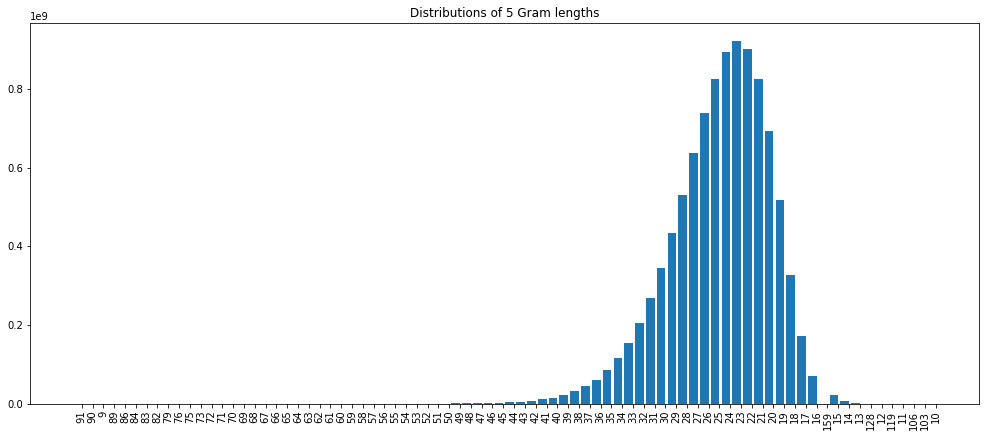

In [109]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("histogram/part-00000").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths")
pl.show()

## 3.  HW5.4.2 <a name="5.4.2"></a>OPTIONAL Question: log-log plots (PHASE 2)
[Back to Table of Contents](#TOC)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## 3.  HW5.5  <a name="5.5"></a> Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3 plus some preprocessing)   (Phase 2)
[Back to Table of Contents](#TOC)

For the remainder of this assignment please feel free to eliminate stop words from your analysis

>There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
 stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,0000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

#### Design notes for TASK (1)
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for TASK (2).

#### Design notes for _TASK (2)_
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

## Example MR stats: (report times!)
    took ~11 minutes on 5 m3.xlarge nodes
    Data-local map tasks=188
	Launched map tasks=190
	Launched reduce tasks=15
	Other local map tasks=2

In [ ]:
# START STUDENT CODE 5.5
# ADD OR REMOVE CELLS AS NEEDED

In [10]:
%%writefile mostFrequentNoStopWords.py
#!~/anaconda2/bin/python

import re
import json
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

#list of stopwords
stopwords = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself',
                 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
                 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these',
                 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
                 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
                 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before',
                 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
                 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
                 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'])

class mostFrequentNoStopWords(MRJob):
    
    SORT_VALUES = True
    
    def count_mapper(self, _, line):
        ngram, count, pages, books = re.split("\t", line)
        words = re.split(" ", ngram)
        count = int(count)
        for word in words:
            word = word.strip().lower()
            if word not in stopwords:
                yield word, count

    def count_reducer(self, word, count):
        yield word, sum(count)

    def init_output_reducer(self):
        # only need top 10,000 words
        self.max = 10000 
        self.topWords = 0 
        
    def output_reducer(self, word, count):
        self.topWords += 1
        if self.topWords <= self.max:
            yield (word, sum(count))
        
    def steps(self):
        return [
            MRStep(
                   mapper = self.count_mapper,
                   combiner = self.count_reducer,
                   reducer = self.count_reducer,
                  jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
            ),
            MRStep(
                   reducer_init = self.init_output_reducer,
                   reducer = self.output_reducer,
                    #sorting/partitioning within jobconf
                   jobconf = {'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                              'mapreduce.partition.keycomparator.options':'-k2,2rn',
                              'mapreduce.job.reduces' : 1,
                              'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
            )
        ]
        
if __name__ == '__main__':
    mostFrequentNoStopWords.run()

Writing mostFrequentNoStopWords.py


__On the test data set:__

In [11]:
#Test on part of file
from mostFrequentNoStopWords import mostFrequentNoStopWords

def run_5_5_1():
    mr_job = mostFrequentNoStopWords(args=['googleNgramsTest.txt'])
    with mr_job.make_runner() as runner:
        runner.run()
        for line in runner.stream_output():
            print mr_job.parse_output_line(line)

run_5_5_1()

(u'aerial', 61)
(u"america's", 98)
(u'american', 172)
(u'apology', 110)
(u'arithmetic', 79)
(u'bibliographical', 56)
(u'bibliography', 145)
(u'bill', 59)
(u'biography', 92)
(u'case', 604)
(u"cat's", 86)
(u'censorship', 98)
(u"child's", 1099)
(u'christmas', 1099)
(u'circumstantial', 62)
(u'city', 62)
(u'collection', 239)
(u'commentary', 110)
(u'comparative', 68)
(u'comparison', 72)
(u'conceptual', 140)
(u'concise', 145)
(u'continuation', 52)
(u'cradle', 86)
(u'critical', 197)
(u'critique', 42)
(u'defence', 398)
(u'dirty', 180)
(u'discovery', 253)
(u'establishing', 59)
(u'eurobond', 59)
(u'fairy', 123)
(u'female', 447)
(u'festschrift', 549)
(u'forms', 116)
(u'framework', 140)
(u'funny', 180)
(u'game', 86)
(u'general', 92)
(u'george', 92)
(u'government', 102)
(u'guide', 140)
(u'handbook', 61)
(u'historical', 558)
(u'history', 25718)
(u'honour', 549)
(u'instruction', 284)
(u'joint', 94)
(u'journey', 59)
(u'juvenile', 68)
(u'key', 135)
(u'lakota', 51)
(u'letters', 52)
(u'life', 298)
(u'limi

__On the full data set:__

In [149]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'MostFrequentNoStopWords')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./mostFrequentNoStopWords.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/tests': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWordsNoStopWords.victoriabaker.20171012.000514.115544
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/mostFrequentWordsNoStopWords.victoriabaker.20171012.000514.115544/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
Running step 1 of 2...
  packageJobJar: [] 

Removing temp directory /tmp/mostFrequentWordsNoStopWords.victoriabaker.20171012.000514.115544...


In [167]:
!hadoop fs -cat {OUTPUT_PATH}/* > ./mostFrequentNoStopWords.txt

In [172]:
!echo "Most Frequent Words with No Stop Words"
!echo "---------------------------------------"
!cat ./mostFrequentNoStopWords.txt | head -10

Most Frequent Words with No Stop Words
---------------------------------------
"case"	41023690
"shall"	37598728
"right"	37390252
"want"	22926367
"head"	20428512
"enough"	17769459
"conditions"	10820194
"doubt"	10335825
"sent"	10026525
"near"	7232154
cat: write error: Broken pipe


In [171]:
#get word 9001 - 10000
!sed -n -e '9001,10000p' mostFrequentNoStopWords.txt > mostFrequentPartial.txt

## Most Frequent Words Stats:
    took 3 minutes, 18 seconds on the altiscale cluster
    
#### Step 1
    Rack-local map tasks = 189
	Launched map tasks = 191
	Launched reduce tasks = 1
	Other local map tasks = 2
    
#### Step 2
    Rack-local map tasks = 2
	Launched map tasks = 2
	Launched reduce tasks = 1
	Other local map tasks = 0

In [202]:
#print the 9001 - 10000 words
with open("./mostFrequentPartial.txt") as f:
    text = f.readlines()
    word_list = [word.split()[0].strip('"') for word in text]

for word in word_list:
    stringified = '"' + word + '"' + ','
    print stringified,

"eyepatch", "electricals", "auteuil", "lslamic", "hotsumi", "extracontinental", "cabarets", "babson", "curtainless", "readjuster", "ofworld", "amethystine", "butane", "uninterpreted", "svn", "gilpin's", "celebrants", "tycoons", "caduceus", "mediche", "ocampo", "sanguineous", "hearses", "astur's", "schafft", "scholastik", "servilities", "disciplinarians", "halfhour", "bellechasse", "striatopallidal", "vsis", "nigtc", "songhai", "drigo", "costive", "plornish", "lnterest", "carrack", "succeedeth", "recrosses", "cosmonaut", "preluded", "blackleg", "monophasic", "wunna", "sundials", "forestalls", "oeconomy", "umkhonto", "netherlandish", "yost", "submerges", "folia", "cheeping", "deluxe", "periampullary", "wardships", "skeptically", "alberts", "cluny's", "schilpp", "fa's", "ionospheric", "plataeans", "osius", "brushy", "terezin", "anschauung", "yeddo", "nowher", "porfiriato", "albee's", "periconceptional", "norseman", "scc", "mordor", "mejores", "pachomius", "philistian", "deinde", "spion", 

In [228]:
%%writefile freqBuildStripes.py
#!~/anaconda2/bin/python

from __future__ import division
import re
import mrjob
import json
import numpy as np
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
from itertools import combinations

#9001 - 10000 words list, as printed above
includeWords = set([ 
    "eyepatch", "electricals", "auteuil", "lslamic", "hotsumi", "extracontinental", "cabarets", "babson", "curtainless", "readjuster", "ofworld", "amethystine", "butane", "uninterpreted", "svn", "gilpin's", "celebrants", "tycoons", "caduceus", "mediche", "ocampo", "sanguineous", "hearses", "astur's", "schafft", "scholastik", "servilities", "disciplinarians", "halfhour", "bellechasse", "striatopallidal", "vsis", "nigtc", "songhai", "drigo", "costive", "plornish", "lnterest", "carrack", "succeedeth", "recrosses", "cosmonaut", "preluded", "blackleg", "monophasic", "wunna", "sundials", "forestalls", "oeconomy", "umkhonto", "netherlandish", "yost", "submerges", "folia", "cheeping", "deluxe", "periampullary", "wardships", "skeptically", "alberts", "cluny's", "schilpp", "fa's", "ionospheric", "plataeans", "osius", "brushy", "terezin", "anschauung", "yeddo", "nowher", "porfiriato", "albee's", "periconceptional", "norseman", "scc", "mordor", "mejores", "pachomius", "philistian", "deinde", "spion", "ateliers", "dolefullest", "spreadest", "kural", "diegesis", "ornithorhynchus", "mennais", "witchetty", "hcn", "composture", "reintegrating", "haemostasis", "riderless", "hawkyard", "cairnvreckan", "propitiously", "neuro", "avantgarde", "comprehensions", "enteroviral", "sickliest", "oppian", "zoser", "tance", "excisemen", "talbots", "hickling", "parastatal", "ruggedly", "strengthener", "agates", "heterosexist", "candies", "celi", "angliam", "postfeminist", "tusschen", "cristero", "bailyn", "depolarizer", "cerchio", "hyrcania", "higden", "selle", "intraepidermal", "montenegrins", "perlman", "nonferromagnetic", "informazione", "gasometer", "seaways", "herms", "illegibility", "pantyhose", "plankings", "dienst", "skrun", "quant", "gropingly", "shipbuilder's", "mayotte", "checkmated", "chowdhury", "vanessa's", "joyner", "macule", "fuerint", "heartwarming", "meal's", "xibalba", "unvanquished", "sheldon's", "nellore", "indiamen", "balthazar", "concepto", "quraysh", "caa", "pesher", "llamo", "yidisher", "thesmophoria", "bourbon's", "imbittered", "icescr", "demonisms", "misheard", "vaude", "preantibiotic", "spokeswoman", "unluckiest", "patroness's", "voci", "endosomes", "convulsant", "desiderium", "underprop", "mittheilungen", "ashtrays", "altas", "regionalized", "bartizan", "musquash", "arbres", "churns", "geistliche", "transiting", "proctitis", "pronunciamentos", "alvars", "masson's", "teague", "pellicles", "leguminosae", "ogillallah", "parusieverzogerung", "wade's", "devize", "saponaceous", "sweezy's", "precurse", "silurien", "roping", "berenice's", "sefton", "flammonde", "onlimited", "accedit", "furloughed", "cousteau", "tsai", "stockjobbing", "bettelheim's", "deconnection", "yagers", "schatzberg", "wing's", "waikiki", "lilongwe", "roquelaure", "tunnelled", "budd's", "cleaveland", "eligibilities", "herrlich", "chetardie", "adequation", "tehachapi", "edite", "prospectiveness", "wim", "chorasan", "sackett's", "hunker", "massachuset's", "suxamethonium", "valors", "dizzied", "sanguinem", "hebd", "lalita", "indemnifies", "renouncer", "knowledg", "tidily", "phenotypically", "blanck", "cogitur", "nyakyusa", "tenaru", "moskovskom", "gajapati", "hypoglossi", "elmslie", "trevoux", "meseta", "theresia", "bamako", "puente", "paleogeography", "offish", "singleside", "lefebvre", "juvenal's", "superheating", "informatica", "fanguine", "arator", "pip's", "myristica", "cotran", "declassification", "spente", "redaktionsgeschichtliche", "curandero", "hanifa", "bandello", "vapouring", "duranty", "virrey", "bedrench", "lasch", "juvenility", "fallodon", "confederacy's", "lobkowitz", "shimoda", "misspending", "hypoechoic", "flowret", "dyscontrol", "semiologie", "tythes", "lettera", "nattered", "undelighted", "germanen", "crouse", "bowenoid", "risc", "laryngological", "weyerhaeuser", "quixotism", "srygley", "capi", "publicola", "givet", "emendatione", "delaval", "toyin", "porthos", "dhhs", "hayesod", "blasius", "pthah", "brandrain", "mutchkin", "canonicis", "skeene", "himyarites", "summarie", "nama", "welcomest", "bertillon", "zygotes", "larding", "sassy", "mattingly", "corleone", "tumed", "vla", "chaldaic", "electroplating", "haymaking", "stanhill", "ideologie", "paleoclimatology", "historicist", "erectors", "montesinos", "cardiacum", "dominacion", "pracharini", "kozlowski", "uptight", "lobos", "svevo", "supplicant's", "labyrinthian", "fframe", "niklaus", "fournal", "metheglin", "breakages", "dioses", "pollicization", "devocion", "principien", "frejus", "heronry", "nociceptors", "disrespected", "libeled", "robustus", "irreprehensible", "mcevedy", "bibliomaniacs", "suicidally", "seascape", "microphase", "supremacists", "formyl", "visperas", "pittura", "greenhead", "brister's", "leasco", "scientiam", "aseem", "gephardt", "archaeoastronomy", "hamartomas", "elisabeth's", "rawalpindi", "maimon", "merlot", "fragilis", "bucentaur", "sparta's", "overseer's", "polyostotic", "deste", "eukaryote", "falsehood's", "key's", "zaghlul", "earle's", "wada", "dhyani", "heweth", "contractarian", "stencils", "hasa", "ftreets", "middleburgh", "bruccoli", "loured", "autotransplantation", "gosson", "invitees", "undented", "principem", "chinampa", "digitization", "cephalothin", "spricht", "coucher", "baeda", "buckskins", "boonies", "melipona", "conglinne", "morisot's", "platonics", "numerosity", "collectibles", "archdologischen", "cytidine", "endometritis", "choeurs", "jurisprudential", "heraldo", "mieke", "voluntaristic", "viele", "recapitalization", "khuddaka", "nightwatch", "remusat", "comorbidities", "gasser", "semipublic", "darnley's", "musculomembranous", "powny", "disconcerts", "copestones", "cabby", "edmondson", "thopas", "tiergarten", "unaging", "chaperons", "uprearing", "jahrzehnten", "seriphus", "casas's", "fondee", "cathected", "gyral", "summerson", "crampt", "aktiengesellschaft", "atalaya", "unpitying", "mandingo", "arnus", "phenylacetic", "steigen", "millenary", "whd", "miglior", "aufidus", "parmenio's", "cyclothems", "lifters", "sternocostal", "repressiveness", "pritchett", "amasi", "telelectroscope", "explique", "schouten", "lanthanides", "unaccusative", "akhdar", "noosphere", "millet's", "motorcar", "wallack's", "crosbie", "paraplegics", "firstname", "loubet", "imprudences", "demission", "gastrins", "genitum", "rhombencephalon", "prosings", "extraosseous", "hynek", "elusion", "hagnon", "alkyd", "osnaburg", "makati", "civilite", "corpuscula", "catoctin", "shipton's", "cashiering", "aere", "dutchies", "plures", "litora", "omniana", "pattes", "arene", "antropologicos", "agrammatism", "iglesias", "wissenschaftstheorie", "neceffities", "marzo", "bagni", "sety", "foker's", "hielandmen", "obedstown", "staatliches", "nonmarital", "limigantes", "roundell", "campgrounds", "spielrein", "doone", "talfourd", "bogy", "crossway", "rushton", "thieve", "foreseeth", "borreliosis", "carlism", "higginbotham's", "rajast", "phaidon", "carabobo", "properent", "embleme", "yehud", "notochordal", "nordau", "boche", "duhem's", "conocer", "extravaganzas", "interstratified", "haydon's", "fiam", "isle's", "frontosphenoidal", "montanas", "obsolescent", "cystatin", "sweeties", "yaba", "salitres", "imaus", "dominos", "plentier", "ekron", "presidentelect", "pennyweights", "acqua", "paramyxoviridae", "dorsocaudal", "fules", "hagar's", "rudas", "vulnera", "darbandi", "theoretischen", "rosalinda", "kiple", "ripas", "rossiiskoi", "gpl", "septentrionale", "riff", "upthrow", "tiefen", "inflecting", "mankynde", "ninette", "multifraction", "tias", "yarde", "nonidentity", "conatus", "brelade", "sibbald", "sona", "asa's", "salvadori", "hunas", "kalasiris", "ternpore", "squelching", "gondar", "disentitled", "sightlessly", "mota", "osnabriick", "penalise", "landleddies", "cingular", "mealtimes", "istituzioni", "gurov", "reconnoissances", "solaris", "invloed", "braudel's", "gartner's", "riffles", "untragic", "charaibs", "psychoanalytischen", "jahreshefte", "statuas", "amatongas", "divitias", "eells", "sykeon", "malinger", "granovetter", "executorship", "hemocyanin", "cobaye", "schwarzenberg", "mug's", "egotisms", "desktops", "utrum", "subinvolution", "conjunctively", "opposability", "deuba", "impalpably", "parce", "impersonator", "narita", "kawena", "palaeographical", "pagod", "fusel", "demiurgus", "sonographically", "thynge", "fuff", "pyoderma", "outmatch", "hozein", "fordone", "recaptors", "ethbaal", "soleis", "khas", "hscientists", "echographic", "meisten", "daimio", "pixie", "appraiser's", "pseudogestational", "xg", "madaura", "broadwood's", "ase", "chasteness", "edibility", "mine's", "faving", "preterites", "vaea", "bizarrerie", "fantom", "dreieinigkeit", "szechuan", "adria's", "horn's", "burros", "correggio's", "geophysique", "fagon", "identidem", "lyghter", "garbe", "frenshe", "rubious", "ruf", "metaplastic", "compassionates", "disertaciones", "nadolol", "amand", "waitara", "entstellt", "shahid", "pocketless", "owyhee", "condy's", "uca", "dartles", "flaherty", "shodden", "bowings", "ousels", "echangees", "kennicott", "concludeth", "chiba", "imw", "confift", "streaky", "rustbelt", "trabb", "doubtfull", "wilno", "maktaba", "parody's", "souvient", "hempel", "norham's", "mercatoria", "schaefer", "prepuberally", "lovyng", "photolithography", "natsume", "ivors", "billerica", "melded", "scap", "incognitos", "deepmere", "lpg", "pharmacodynamiques", "propinquorum", "myrtilus", "amiyo", "goalie", "wallrock", "jaffrey's", "employeth", "metatheoretical", "wived", "murdstone", "biologica", "graphitic", "mitscherlich", "gieson", "luangwa", "magnificoes", "marden", "cowing", "bairnly", "fources", "varada", "verdnderungen", "macnair", "chaprer", "midwest's", "slaver's", "equalness", "supernaturalists", "volens", "bauten", "salpingo", "satyr's", "wyeth's", "thingly", "cityscape", "moch", "termor", "scholastically", "liaodong", "ditched", "byles", "nonlexical", "tekhniki", "keraki", "sconced", "gioras", "abvd", "marybone", "allaby", "blushingly", "neathe", "housemaid's", "augural", "farmyards", "reprehenderit", 
"civilian's", "hypnagogic", "peniel", "pugno", "barberry's", "antenatally", "oui", "isochron", "greenlaw", "unt", "cuchumatan", "aryanization", "djoser", "sentement", "adelaide's", "sacrosanctum", "disencumbering", "monopolar", "rabinovich", "poss", "handcart", "possessione", "caerlion", "henslowe's", "koichi", "biencourt", "ludovick", "suppurate", "sagrado", "osmanli", "nostrorum", "proefrock", "norteamericana", "gringos", "oflntergroup", "sandpaintings", "detonates", "temenus", "waraka", "barnum's", "csel", "gusting", "dilthey's", "phet", "miramar", "lba", "palaearctic", "augite", "verwendung", "turnstiles", "ravensworth", "laurer", "daweth", "leuk", "foundeth", "gregors", "bohman", "judicialization", "speedest", "thromboemboli", "walthamstow", "equilibriums", "sarbar", "nonblank", "elhanan", "cfoflfdfefr", "rosch", "homodimers", "overemphasised", "hollars", "assegai", "sustento", "tulliver's", "swoonings", "epineurium", "lurker", "sitot", "gsal", "weinzweig", "gelfoam", "breisach", "wathelyne", "hobbist", "perrys", "loosenesses", "coughings", "berzeliuses", "unshrunken", "frascina", "lepanto's", "counteroffers", "bohme", "baue", "oikeiosis", "enchantment's", "pamphylian", "gwilym", "anger's", "kircubbin", "oulu", "spinosa", "yuzpe", "bagre", "moutons", "unrigged", "masers", "shentleman's", "wasser", "entuned", "medicin", "sackless", "moshesh", "scratchings", "artabazus", "grenadier's", "laughters", "hermoso", "champignons", "arava", "gonadotroph", "selfportrait", "polycythaemia", "sarto's", "nicias's", "aztecas", "stalkers", "veitch", "deprest", "apcs", "syncopal", "salians", "denatures", "drumclog", "behould", "adminstration", "clawson", "loquela", "henke", "ultimas", "murrough", "bodach", "dfe", "pofture", "vcjd", "tnot", "fallersleben", "commutativity", "barcaldine", "overdependency", "procerity", "louisiana's", "paysanne", "bsd", "nervie", "saxitoxin", "canevas", "moab's", "equipoises", "oppida", "standardising", "rimer", "polysomes", "monthlies", "rampaged", "apoptosome", "esterhazy", "coppage", "prooucts", "terrifick", "destroyer's", "sistrum", "dependent's", "antiarmy", "gangliocytomas", "ursicinus", "nuck", "totis", "philatelic", "opsi", "thevenin's", "smoke's", "morakanabad", "aniversario", "zeila", "eets", "bartender's", 
"illogically", "verticity", "manquer", "insphering", "beck's", "wholy", "deinen" ])

class freqBuildStripes(MRJob):


    def mapper(self, _, line):
        #Emit co-occurrence combos for each pair of words stored as stripes
        line = line.strip().split('\t')
        
        #The full text of the ngram
        ngram = line[0].lower()
        words = ngram.split(" ")
        count = int(line[1])
        output = {}
        
        for w in words:
            #only print stripe if it contains a word in the list
            if w in includeWords:
                #add each combination of co-occurring words to stripe
                for w1, w2 in combinations(words, 2):
                    if w1 in output.keys():
                        output[w1][w2] = output[w1].get(w2,0) + count
                    else:
                        output[w1] = {w2:count}

                    #mirroring word order so both a,b and b,a get added
                    if w2 in output.keys():      
                        output[w2][w1] = output[w2].get(w1,0) + count
                    else:
                        output[w2] = {w1:count}
            else:
                pass

        for word, groups in output.iteritems():
            yield word, groups

    def reducer(self, word, groups):
        #combine stripe totals
        output_dict = {}
        for co in groups:
            for coWord, count in co.iteritems():
                output_dict[coWord] = output_dict.get(coWord,0) + count
        yield word, output_dict     
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.reducer,
                reducer = self.reducer,
                jobconf = {'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40 }
                  )        
        ] 

if __name__ == '__main__':
      freqBuildStripes.run()

Overwriting freqBuildStripes.py


__On the test data set:__

In [230]:
!hdfs dfs -rm --recursive stripesOutput
!python freqBuildStripes.py -r local googleNgramsTest.txt > stripesOutput

-rm: Illegal option --recursive
Usage: hadoop fs [generic options] -rm [-f] [-r|-R] [-skipTrash] <src> ...
No configs found; falling back on auto-configuration
Creating temp directory /tmp/freqBuildStripes.victoriabaker.20171012.020519.272103
Running step 1 of 1...
Streaming final output from /tmp/freqBuildStripes.victoriabaker.20171012.020519.272103/output...
Removing temp directory /tmp/freqBuildStripes.victoriabaker.20171012.020519.272103...


In [231]:
#probably won't output anything in small dataset. When you add "key" to the 
#includeWords list, results are printed.
!cat stripesOutput

__On the full data set:__

In [233]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'freqBuildStripes')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./freqBuildStripes.py \
        -r hadoop hdfs:///user/winegarj/data/full \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/552_Outputs/stripesOutput': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/freqBuildStripes.victoriabaker.20171012.020540.869444
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/freqBuildStripes.victoriabaker.20171012.020540.869444/files/...
Detected hadoop configuration property names that do not match hadoop version 2.7.3:
The have been translated as follows
 mapred.map.tasks: mapreduce.job.maps
mapred.reduce.tasks: mapreduce.job.reduces
Running step 1 of 1...
  packageJobJar: [] [/op

In [234]:
!hadoop fs -cat {OUTPUT_PATH}/* > ./freqBuildStripes_output.txt

In [235]:
!echo "Stripes"
!echo "---------------------------------------"
!cat ./freqBuildStripes_output.txt | head -10

Stripes
---------------------------------------
"akademischer"	{"austausch": 86, "the": 86, "dienst": 86, "deutscher": 86}
"amatongas"	{"zulus": 277, "among": 277, "the": 277, "and": 277}
"ambassador"	{"and": 59, "united": 47, "yost": 157, "by": 110, "in": 98, "the": 47, "subsequently": 110}
"amin"	{"and": 61, "shahid": 61, "by": 61, "dipesh": 61}
"amitabha"	{"of": 139, "the": 139, "dhyani": 139, "buddha": 139}
"amittenda"	{"possessione": 45, "adquirenda": 45, "de": 45, "vel": 45}
"artabazus"	{"daughter": 60, "that": 55, "wall": 55, "of": 117, "son": 57, "pharnaces": 57, "to": 94, "preserved": 55, "carry": 47, "the": 219, "barsine": 60}
"artery"	{"of": 79, "detected": 79, "sonographically": 79, "carotid": 79}
"attacks"	{"and": 47, "a": 91, "which": 44, "very": 44, "syncopal": 91, "to": 44, "influences": 44, "in": 47, "nordau": 44, "tendency": 44}
"audit"	{"et": 63, "identidem": 63, "te": 63, "spectat": 63}
cat: write error: Broken pipe


## Build Stripes Stats:
    took 1 minute, 46 seconds on the altiscale cluster
    Rack-local map tasks = 189
	Launched map tasks = 191
	Launched reduce tasks = 40
	Other local map tasks = 2

#### Note:
Using the same invertedIndex class defined at the beginning of this notebook. 

In [243]:
!hdfs dfs -rm --recursive invertedIndexOutput
!python invertedIndex.py -r local freqBuildStripes_output.txt > invertedIndexOutput

-rm: Illegal option --recursive
Usage: hadoop fs [generic options] -rm [-f] [-r|-R] [-skipTrash] <src> ...
No configs found; falling back on auto-configuration
Creating temp directory /tmp/invertedIndex.victoriabaker.20171012.023155.535799
Running step 1 of 1...
Streaming final output from /tmp/invertedIndex.victoriabaker.20171012.023155.535799/output...
Removing temp directory /tmp/invertedIndex.victoriabaker.20171012.023155.535799...


__On the test data set:__

In [244]:
!cat invertedIndexOutput

"theater"	{"new":59,"wallack's":15,"at":291,"in":1000}
"theatre"	{"to":747,"as":185,"wallack's":15,"fast":4}
"their"	{"all":84,"just":10,"being":23,"loungers":4,"undelighted":13,"bigoted":4,"through":40,"world":28,"transiting":17,"wanton":5,"horn's":13,"to":747,"riding":4,"them":30,"returned":4,"gusting":11,"chorasan":18,"novelists":4,"furloughed":14,"five":6,"diamonded":4,"own":23,"wasser":16,"easily":8,"vanessa's":20,"skills":4,"tunnelled":19,"plataeans":18,"haymaking":22,"house":32,"tidily":28,"jupiter":4,"pale":4,"shearing":4,"folk":10,"disencumbering":8,"panes":4,"be":172,"rung":5,"seventh":5,"bestow":8,"haemostasis":12,"masson's":22,"buddhas":6,"distressed":8,"of":1939,"curtainless":18,"according":12,"british":13,"threat":4,"sweetness":4,"tasks":4,"successive":4,"breakages":18,"allegiance":4,"hollow":4,"down":40,"services":18,"miss":24,"boat":4,"from":237,"defacements":4,"girls":4,"arms":8,"panoply":4,"way":40,"outmatch":15,"themselves":12,"breathe":4,"that":289,"ivors":11,"about

"marques"	{"mota":11,"the":2161,"de":279,"la":115}
"marquis"	{"sicily":4,"la":115,"of":1939,"de":279,"corleone":13,"in":1000,"the":2161,"chetardie":4}
"marriage"	{"and":1647,"of":1939,"the":2161,"fournal":10}
"marriages"	{"and":1647,"of":1939,"english":30,"in":1000,"the":2161,"wardships":15}
"married"	{"about":63,"allaby":18,"talked":4,"having":16}
"marrow"	{"solid":5,"tumors":4,"autotransplantation":15,"for":240,"bone":8}
"marry"	{"lord":30,"to":747,"her":94,"deepmere":16}
"marshal"	{"and":1647,"wade's":19,"of":1939,"schwarzenberg":8,"proceedings":4,"in":1000,"blucher":4,"during":20}
"marx"	{"theoretischen":12,"grundlegenden":4,"von":41,"konstruktion":4}
"mary"	{"and":1647,"edited":14,"pukui":6,"samuel":4,"kawena":6,"bruccoli":8,"translated":9,"jean":4,"by":295}
"marybone"	{"fields":8,"islington":4,"from":237,"to":747}
"maryland's"	{"catoctin":8,"retreat":4,"presidential":4,"in":1000}
"marzo"	{"february":5,"march":10,"junio":4,"abril":8,"may":45,"mayo":8,"febrero":7,"april":6}
"mas"	{

"and"	{"writings":8,"granoff":4,"colleges":4,"yellow":8,"narcotic":5,"hath":8,"woods":4,"sleep":4,"captain":4,"killegrew":6,"rouse":6,"presents":4,"sorrentino":4,"under":36,"tyrannies":4,"nourisher":4,"screamings":3,"propane":7,"risc":15,"scratchings":7,"jack":4,"upstream":4,"jacob":12,"proctitis":17,"school":15,"bewildered":9,"atalaya":17,"cause":4,"herbert":4,"force":6,"japanese":4,"nodosum":4,"surrounding":7,"edmondson":12,"bipolar":4,"cotes":4,"new":59,"net":4,"barometer":4,"icescr":7,"men":25,"counteroffers":8,"drew":4,"protection":4,"multivitamins":4,"knetsch":4,"darbandi":5,"substance":4,"pronunciamentos":16,"study":14,"economics":4,"schouten":11,"nuruddin":5,"seaways":13,"carl":6,"classification":4,"correggio's":17,"pantyhose":13,"dna":4,"would":74,"army":12,"cabarets":13,"music":18,"therefore":7,"nonmarital":11,"hahn":9,"striatopallidal":7,"sauvignon":4,"terrifick":10,"hereby":4,"robbins":4,"pancreatic":6,"brushy":18,"unergative":4,"glass":8,"tg":4,"ozaki":4,"shahid":10,"dietm

__On the full data set:__

In [240]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'invertedIndex_2')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./invertedIndex.py \
        -r hadoop freqBuildStripes_output.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

17/10/12 02:25:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/553_Outputs/invertedIndexOutput' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/victoriabaker/.Trash/Current
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex.victoriabaker.20171012.022526.519507
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/invertedIndex.victoriabaker.20171012.022526.519507/files/...
Detected hado

In [241]:
!hadoop fs -cat {OUTPUT_PATH}/* > ./invertedIndex_output.txt

In [242]:
!echo "Inverted Indexes"
!echo "---------------------------------------"
!cat ./invertedIndex_output.txt | head -10

Inverted Indexes
---------------------------------------
"akademischer"	{"austausch": 4, "the": 2161, "dienst": 20, "deutscher": 4}
"amatongas"	{"and": 1647, "among": 25, "the": 2161, "zulus": 4}
"ambassador"	{"and": 1647, "subsequently": 5, "united": 12, "yost": 20, "in": 1000, "the": 2161, "by": 295}
"amin"	{"and": 1647, "shahid": 10, "by": 295, "dipesh": 4}
"amitabha"	{"of": 1939, "the": 2161, "dhyani": 9, "buddha": 4}
"amittenda"	{"possessione": 10, "adquirenda": 4, "de": 279, "vel": 4}
"artabazus"	{"daughter": 13, "that": 289, "wall": 8, "of": 1939, "son": 14, "pharnaces": 4, "to": 747, "preserved": 9, "carry": 3, "the": 2161, "barsine": 4}
"artery"	{"of": 1939, "detected": 8, "sonographically": 13, "carotid": 4}
"attacks"	{"a": 672, "and": 1647, "which": 124, "very": 32, "syncopal": 10, "to": 747, "influences": 8, "in": 1000, "nordau": 16, "tendency": 7}
"audit"	{"et": 144, "identidem": 15, "te": 7, "spectat": 4}
cat: write error: Broken pipe


## Inverted Index Stats:
    took 1 minute, 45 seconds on the altiscale cluster
    Rack-local map tasks = 40
	Launched map tasks = 40
	Launched reduce tasks = 40

In [266]:
%%writefile MRsimilarity.py
#!~/anaconda2/bin/python

from __future__ import division
import collections
import re
import csv
import json
import numpy as np
from math import sqrt
from itertools import combinations
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRsimilarity(MRJob):
    #essentially the same as the similarity job in the first part of this assignment
    SORT_VALUES = True
    
    def mapper(self, _, line):
        word, stripe = line.split('\t')
        stripe = json.loads(stripe)
        docs = stripe.keys()
        for words in combinations(docs, 2):
            pair = sorted(list(words))
            w1 = pair[0]
            w2 = pair[1]
            yield (w1,w2), [1, stripe[w1], stripe[w2]]
                                        
    def reducer(self, pair, stripes):
        a_b = 0
        
        for stripe in stripes:
            pairCount, a, b = stripe[:3]
            a_b += pairCount
            
        jaccard = a_b / float(a + b - a_b)
        cosine = a_b * (1 / sqrt(a) * 1 / sqrt(b))
        overlap = a_b / min(a, b)
        dice = (2 * a_b) / (a + b)
        avg = (jaccard + cosine + overlap + dice ) / float(4)
        
        yield avg, [pair, cosine, jaccard, overlap, dice]
    
    def reducer2(self, word, values):
        for value in values:
            yield word, value

    def steps(self):
        return [MRStep(
            mapper = self.mapper,
            reducer = self.reducer,
        ),
            MRStep(
            reducer = self.reducer2,
            jobconf = {
                'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                       'mapred.text.key.comparator.options':'-k1,1rn',
                       'mapred.map.tasks' : 40, 'mapred.reduce.tasks' : 40}   
        )
               ]
    
if __name__ == '__main__':
    MRsimilarity.run()

Overwriting MRsimilarity.py


__On the test data set:__

In [260]:
!hdfs dfs -rm --recursive similarity_output
!python MRsimilarity.py -r local invertedIndex_output.txt  > similarity_output

-rm: Illegal option --recursive
Usage: hadoop fs [generic options] -rm [-f] [-r|-R] [-skipTrash] <src> ...
No configs found; falling back on auto-configuration
Creating temp directory /tmp/MRsimilarity.victoriabaker.20171012.030020.503727
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/MRsimilarity.victoriabaker.20171012.030020.503727/output...
Removing temp directory /tmp/MRsimilarity.victoriabaker.20171012.030020.503727...


In [261]:
!cat similarity_output | head -10

0.0038524951	[["der","of"],0.0024347337,0.0004938272,0.0114942529,0.0009871668]
0.0042579564	[["et","with"],0.0043033148,0.0019305019,0.0069444444,0.0038535645]
0.0046828449	[["at","et"],0.0048850865,0.0023041475,0.0069444444,0.0045977011]
0.0047514027	[["et","on"],0.0049801192,0.0023640662,0.0069444444,0.0047169811]
0.0054117978	[["et","his"],0.0059222421,0.0029325513,0.0069444444,0.0058479532]
0.0054425883	[["et","is"],0.005967624,0.0029585799,0.0069444444,0.005899705]
0.0056441346	[["by","und"],0.0056550449,0.0025,0.0094339623,0.0049875312]
0.0056726942	[["at","und"],0.0056937786,0.0025252525,0.0094339623,0.0050377834]
0.0057005672	[["be","et"],0.0063541071,0.0031746032,0.0069444444,0.0063291139]
0.0057543138	[["on","und"],0.0058045433,0.0025974026,0.0094339623,0.0051813472]
cat: write error: Broken pipe


__On the full data set:__

In [267]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'MRsimilarity')
!hadoop fs -rm -r {OUTPUT_PATH}
!python ./MRsimilarity.py \
        -r hadoop invertedIndex_output.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output \
        --no-strict-protocol

rm: `/user/victoriabaker/554_Outputs/similarityOutput': No such file or directory
No configs found; falling back on auto-configuration

Non-strict protocols are deprecated and will be removed in v0.6.0. Please run your job with --strict-protocols and fix any underlying encoding issues

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/MRsimilarity.victoriabaker.20171012.033807.921246
Copying local files to hdfs:///user/victoriabaker/tmp/mrjob/MRsimilarity.victoriabaker.20171012.033807.921246/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1393154641680478770.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connectin

Removing temp directory /tmp/MRsimilarity.victoriabaker.20171012.033807.921246...


In [268]:
!hadoop fs -cat {OUTPUT_PATH}/* > ./similarityOutput.txt

In [269]:
!echo "Similarity"
!echo "---------------------------------------"
!cat ./similarityOutput.txt | head -10

Similarity
---------------------------------------
0.7537993155853	[["oulu", "wilno"], 0.7453559924999299, 0.55555555555555558, 1.0, 0.7142857142857143]
0.68602148205366287	[["esther", "summerson"], 0.68853037265909622, 0.5, 0.88888888888888884, 0.66666666666666663]
0.62164443315122297	[["miss", "murdstone"], 0.62275236877952778, 0.42307692307692307, 0.84615384615384615, 0.59459459459459463]
0.49513673220832283	[["moccasin", "put"], 0.44721359549995793, 0.20000000000000001, 1.0, 0.33333333333333331]
0.49513673220832283	[["enteroviral", "plankings"], 0.44721359549995798, 0.20000000000000001, 1.0, 0.33333333333333331]
0.49513673220832283	[["parmenio's", "plankings"], 0.44721359549995798, 0.20000000000000001, 1.0, 0.33333333333333331]
0.49513673220832283	[["ousels", "plankings"], 0.44721359549995798, 0.20000000000000001, 1.0, 0.33333333333333331]
0.49513673220832283	[["bucentaur", "plankings"], 0.44721359549995798, 0.20000000000000001, 1.0, 0.33333333333333331]
0.49513673220832283	[["scho

## Similarity Stats:
#### Step 1
    took 15 minutes, 34 seconds on the altiscale cluster
    Rack-local map tasks = 3
	Launched map tasks = 3
	Launched reduce tasks = 1

#### Step 2
    took 2 minutes, 24 seconds on the altiscale cluster
    Rack-local map tasks = 41
	Launched map tasks = 41
	Launched reduce tasks = 41 

In [270]:
!sort -k1,1nr similarityOutput.txt > sortedSimilarityOutput.txt

In [271]:
!head sortedSimilarityOutput.txt

1.0	[["acad", "sci"], 0.99999999999999989, 1.0, 1.0, 1.0]
1.0	[["adsciscit", "alienas"], 1.0, 1.0, 1.0, 1.0]
1.0	[["animal", "lepidosiren"], 1.0, 1.0, 1.0, 1.0]
1.0	[["appendix", "exhibens"], 1.0, 1.0, 1.0, 1.0]
1.0	[["ater", "scire"], 1.0, 1.0, 1.0, 1.0]
1.0	[["avant", "romantique"], 1.0, 1.0, 1.0, 1.0]
1.0	[["background", "joshua's"], 1.0, 1.0, 1.0, 1.0]
1.0	[["banquets", "colleges"], 1.0, 1.0, 1.0, 1.0]
1.0	[["beginning", "remainder"], 1.0, 1.0, 1.0, 1.0]
1.0	[["catalla", "parentum"], 1.0, 1.0, 1.0, 1.0]


In [272]:
!head -20 sortedSimilarityOutput.txt > top_bottom_20.txt
!tail -20 sortedSimilarityOutput.txt >> top_bottom_20.txt
!head -1000 sortedSimilarityOutput.txt > top1000sims

In [273]:
import json
sortedSims = []
with open('top_bottom_20.txt') as f:
    for line in f.readlines():
        line = line.strip()
        avg, stripe = line.split('\t')
        stripe = json.loads(stripe)
        stripe.append(avg)
        sortedSims.append(stripe)

In [ ]:
# END STUDENT CODE 5.5

In [274]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by cosine"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117

for stripe in sortedSims[:20]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )

print '—'*117

for stripe in sortedSims[-20:]:
    print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
        stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(stripe[5]) )



Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
             [u'acad', u'sci'] |       1.000000 |       1.000000 |       1.000000 |       1.000000 |       1.000000
    [u'adsciscit', u'alienas'] |       1.000000 |       1.000000 |       1.000000 |       1.000000 |       1.000000
   [u'animal', u'lepidosiren'] |       1.000000 |       1.000000 |       1.000000 |       1.000000 |       1.000000
    [u'appendix', u'exhibens'] |       1.000000 |       1.000000 |       1.000000 |       1.000000 |       1.000000
           [u'ater', u'scire'] |       1.000000 |       1.000000 |       1.000000 |       1.0

In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

## 3.  HW5.6  <a name="5.6"></a> Evaluation of synonyms that your discovered
[Back to Table of Contents](#TOC)


In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [12]:
#installing for final analysis as instructed
!pip install nltk
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/victoriabaker/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("./top1000sims","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 3 out of top 1000
Number of words without synonyms: 829
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.00307503075031
Recall		0.00143501435014
F1		0.00192701927019
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] acad
[] sci
[] adsciscit
[] alienas
[] lepidosiren
[] exhibens
[] ater
[] scire
[] avant
[] romantique
[] joshua's
[] catalla
[] parentum
[] chloro
[] proprietes
[] choshu
[] clivo
[] steedman
[] constat
[] pulmones
[] detraxit
[] durus
[] divarsion
[] laffin
[] elektronischer
[] verlages
[] elettronica
[] fieri
[] gentilidad
[] lluvia
[] hyppigere
[] sunde
[] iniectio
[] injectio
[] libidin

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

## 3.  HW5.7  <a name="5.7"></a> OPTIONAL: using different vocabulary subsets
[Back to Table of Contents](#TOC)


Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## 3.  HW5.8  <a name="5.8"></a> OPTIONAL: filter stopwords
[Back to Table of Contents](#TOC)

There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



## 3.  HW5.9 <a name="5.9"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## 3.  HW5.10 <a name="5.10"></a> OPTIONAL 
[Back to Table of Contents](#TOC)

Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?